In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [2]:
# Load the full CI logs dataset
df = pd.read_csv("../data/all_logs.csv")

# Preview structure
df.head()


,timestamp,command,duration_s,exit_code,cpu_pct_avg,mem_kb_max,tag,status,pipeline_id
0,2025-06-15 07:17:52,"docker login -u ""gitlab-ci-token"" -p ""glcbt-ey...",0.50,0,6.10,0,unknown,pass,1.870500e+09
1,2025-06-15 07:19:14,"docker build -t ""registry.gitlab.com/uhthesis/...",82.14,0,40.59,46396,unknown,pass,1.870500e+09
2,2025-06-15 07:20:06,"docker push ""registry.gitlab.com/uhthesis/bids...",51.59,0,55.48,37844,unknown,pass,1.870500e+09
3,2025-06-15 07:21:05,flake8 .,1.00,0,48.15,22600,unknown,pass,1.870500e+09
4,2025-06-15 07:22:02,python manage.py collectstatic --noinput,0.50,0,35.40,0,unknown,pass,1.870500e+09


In [3]:
# Drop columns we don't want
df = df.drop(columns=["command", "exit_code", "pipeline_id"])

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Drop timestamp if you don't need time-series modeling
df = df.drop(columns=["timestamp"])

# Convert memory to MB
df["mem_mb"] = df["mem_kb_max"] / 1024
df.drop(columns=["mem_kb_max"], inplace=True)

# Log-transform duration
df["log_duration"] = np.log1p(df["duration_s"])
df.drop(columns=["duration_s"], inplace=True)

# Encode tag (CI stage)
df["tag_code"] = df["tag"].astype("category").cat.codes
df.drop(columns=["tag"], inplace=True)

# Encode target
df["status"] = df["status"].map({"pass": 1, "fail": 0})

# Final preview
df.head()

# result - 6 columns representing the 6 input features
# tag column refers to the CI job type - 0 = build, 1 = lint, 2 = test


,cpu_pct_avg,status,hour,dayofweek,mem_mb,log_duration,tag_code
0,6.10,1,7,6,0.000000,0.405465,3
1,40.59,1,7,6,45.308594,4.420526,3
2,55.48,1,7,6,36.957031,3.962526,3
3,48.15,1,7,6,22.070312,0.693147,3
4,35.40,1,7,6,0.000000,0.405465,3


In [4]:
X = df.drop("status", axis=1)
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

# result - example: ((231, 6), (58, 6)) = 231 samples in the training set, 58 samples in the test set, Each with 6 features


((266, 6), (67, 6))

In [5]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=["fail", "pass"]))


Logistic Regression Performance
              precision    recall  f1-score   support

        fail       0.22      0.78      0.34         9
        pass       0.94      0.57      0.71        58

    accuracy                           0.60        67
   macro avg       0.58      0.67      0.53        67
weighted avg       0.85      0.60      0.66        67



In [6]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=["fail", "pass"]))


Random Forest Performance
              precision    recall  f1-score   support

        fail       0.86      0.67      0.75         9
        pass       0.95      0.98      0.97        58

    accuracy                           0.94        67
   macro avg       0.90      0.82      0.86        67
weighted avg       0.94      0.94      0.94        67



In [7]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb, target_names=["fail", "pass"]))


XGBoost Performance
              precision    recall  f1-score   support

        fail       0.58      0.78      0.67         9
        pass       0.96      0.91      0.94        58

    accuracy                           0.90        67
   macro avg       0.77      0.85      0.80        67
weighted avg       0.91      0.90      0.90        67



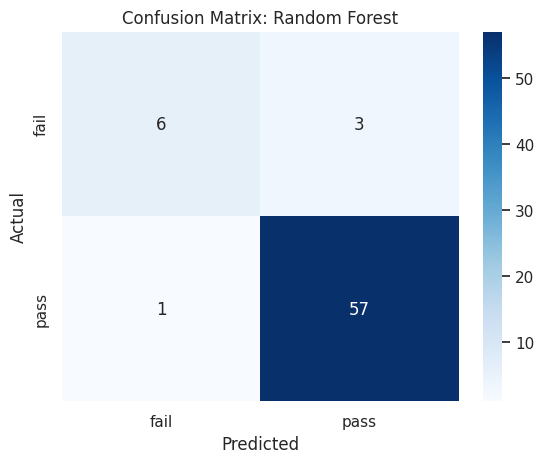

In [8]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["fail", "pass"], yticklabels=["fail", "pass"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [9]:
importances = rf.feature_importances_
features = X_train.columns

for feat, score in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(f"{feat:15} → {score:.3f}")

cpu_pct_avg     → 0.465
mem_mb          → 0.207
log_duration    → 0.131
hour            → 0.110
tag_code        → 0.059
dayofweek       → 0.028


In [10]:
import joblib
joblib.dump(rf, "rf_model.joblib")

['rf_model.joblib']